## Bibliotecas

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl as opx
import scipy.optimize as scy
from lmfit import Model

## Importando Arquivo de dados


In [86]:
#importando excel, precisa colocar o endereço de onde está o excel
wb=opx.load_workbook(r'E:\eduro\Documents\Graduação ITA\Iniciação científica\Criação de dados para testar\dados_impedancia.xlsx')
#abrindo página de localização da tabela
ws=wb['Sheet1']

In [87]:
# Função para ler a tabela do Excel
def create_df_from_excel(ws,nome_da_tabela):
    mapping = {}

    for entry, data_boundary in ws.tables.items():
        #parse the data within the ref boundary
        data = ws[data_boundary]
        #extract the data 
        #the inner list comprehension gets the values for each cell in the table
        content = [[cell.value for cell in ent] 
                for ent in data
            ]
        header = content[0]
        #the contents ... excluding the header
        rest = content[1:]
        #create dataframe with the column names
        #and pair table name with dataframe
        df = pd.DataFrame(rest, columns = header)
        mapping[entry] = df
    return mapping[nome_da_tabela]


In [88]:
df=create_df_from_excel(ws,'Table1')
df.dropna(how='all',inplace=True)

In [89]:
# Renomenado as colunas
df.rename(columns={'Column1':'Omega','Column2':'Impedance_Real','Column3':'Impedance_Imaginary'},inplace=True)
df['Impedance_Imaginary']=np.abs(df['Impedance_Imaginary'])

## Plotagem dos pontos do Excel


Text(0, 0.5, 'Impedância Imaginária')

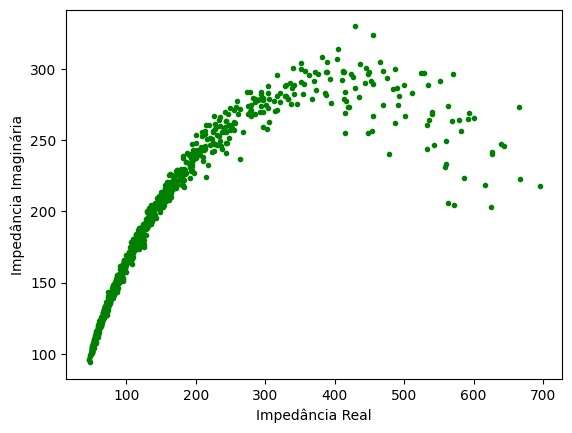

In [90]:
fig, axs = plt.subplots(1, 1)
plt.plot(df['Impedance_Real'],np.abs(df['Impedance_Imaginary']),'g.')
plt.xlabel('Impedância Real')
plt.ylabel('Impedância Imaginária')

## Criação de Funções para ajustar os pontos

In [91]:
# Parte Real
def func_real(w,R,t,a):
    f=R*(1+np.cos((1-a)*np.pi/2)*(w*t)**(1-a))/(1+ (w*t)**(2-2*a) +2*np.cos((1-a)*np.pi/2)*(w*t)**(1-a))
    return f
# Parte Imaginária
def func_im(w,R,t,a):
    f=np.abs(-1*R*(np.sin((1-a)*np.pi/2)*(w*t)**(1-a))/(1+ (w*t)**(2-2*a) +2*np.cos((1-a)*np.pi/2)*(w*t)**(1-a)))
    return f
# Função complexa como soma das partes
def impd(w,R,t,a):
    f=func_real(w,R,t,a)+1j*func_im(w,R,t,a)
    return f
# Função complexa sem ter separada as parte reais e imaginárias
def impd2(w,R,t,a):
    f=R/(1+(1j*w*t)**(1-a))
    return f
# Função módulo do numero complexo
def modulo(w,R,t,a=10**-2):
    f=np.sqrt(func_real(w,R,t,a)**2+func_im(w,R,t,a)**2)    
    return f

## Fit pela função módulo

C:\Users\eduro\AppData\Local\Temp\ipykernel_31636\2724256061.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.Impedance=np.sqrt(df['Impedance_Real']**2 + df['Impedance_Imaginary']**2)


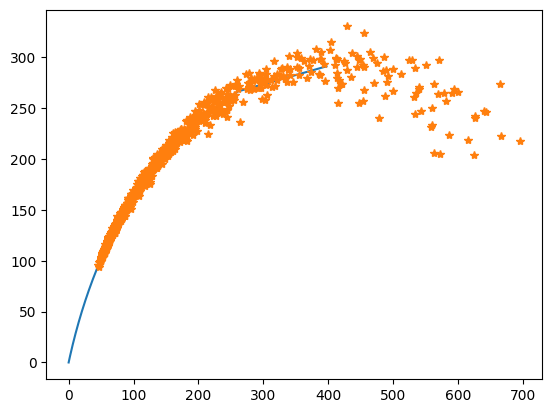

In [96]:
# Criação de uma coluna com os valores do módulo da impedância
df.Impedance=np.sqrt(df['Impedance_Real']**2 + df['Impedance_Imaginary']**2)

# Ajuste segundo a função módulo do número complexo
popt_mod, pcov = scy.curve_fit(modulo, df.Omega, df.Impedance,p0=[500,10**-5,1],method='lm',maxfev=1000)

#Plotagem dos pontos com os parâmetros calculados
xx=np.linspace(10**3,8*10**8,1000000)
z_im=func_im(xx,*popt_mod)
z_real=func_real(xx,*popt_mod)
plt.plot(abs(z_real),abs(z_im))
plt.plot(df['Impedance_Real'],df['Impedance_Imaginary'],'*')

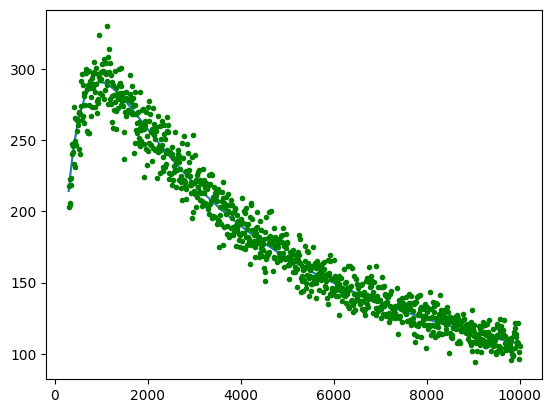

In [97]:
# PLotagem da parte Imaginária com a frequência em omega
plt.plot(df.Omega,func_im(df.Omega,*popt_mod))
plt.plot(df.Omega,df['Impedance_Imaginary'],'g.')

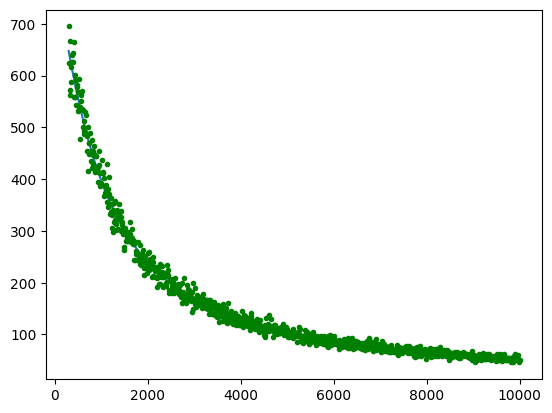

In [98]:
# PLotagem da parte Real com a frequência em omega
plt.plot(df.Omega,func_real(df.Omega,*popt_mod))
plt.plot(df.Omega,df['Impedance_Real'],'g.')